In [1]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from vic.dataloader import load_orl, make_fixed_test_indices, split_with_fixed_test
from vic.models import LBPH, Eigenfaces, DeepLearningModel

In [4]:
def evaluate_models_vs_train_size(
    models: dict,  # {"Eigenfaces": model, "LBPH": model}
    train_sizes: list[int],
    data: dict,
    test_idx: dict,
    pool_idx: dict,
    n_exp: int = 10,
    seed_master: int = 0,
    save_path: str = "logs/results.json",
):
    # -------------------------
    # Load previous results if they exist
    # -------------------------
    save_path = Path(save_path)
    if os.path.exists(save_path):
        with open(save_path) as f:
            results = json.load(f)
        print(f"[INFO] Loaded existing results from {save_path}")
    else:
        results = {}

    rng = np.random.default_rng(seed_master)
    for model_name, model_fn in models.items():
        print(f"\n=== Model: {model_name} ===")

        results.setdefault(model_name, {})

        for train_size in train_sizes:
            results[model_name].setdefault(str(train_size), [])

            existing_runs = len(results[model_name][str(train_size)])
            remaining = n_exp - existing_runs

            if remaining <= 0:
                print(f"  [SKIP] train_size={train_size} already done")
                continue

            print(f"  train_size={train_size} ({existing_runs}/{n_exp} done)")

            for _ in tqdm(range(remaining), desc="    runs", leave=False):
                seed = int(rng.integers(0, 1e6))

                Xtr, ytr, Xte, yte = split_with_fixed_test(
                    data,
                    test_idx,
                    pool_idx,
                    train_size,
                    seed=seed,
                )
                model = model_fn()

                model.fit(Xtr, ytr)
                y_pred = model.predict(Xte)

                acc = accuracy_score(yte, y_pred)
                results[model_name][str(train_size)].append(acc)

                with open(save_path, "w") as f:
                    json.dump(results, f, indent=2)

    return results


def summarize_results(results: dict):
    summary = {}

    for model_name, model_res in results.items():
        summary[model_name] = {}

        for train_size, accs in model_res.items():
            accs = np.array(accs, dtype=float)
            summary[model_name][int(train_size)] = {
                "mean": accs.mean(),
                "std": accs.std(),
            }

    return summary


def plot_learning_curves(summary: dict):
    plt.figure(figsize=(7, 5))

    for model_name, model_res in summary.items():
        sizes = sorted(model_res.keys())
        means = [model_res[s]["mean"] for s in sizes]
        stds = [model_res[s]["std"] for s in sizes]

        sizes = np.array(sizes)
        means = np.array(means)
        stds = np.array(stds)

        plt.plot(sizes, means, marker="o", label=model_name)
        plt.fill_between(
            sizes,
            means - stds,
            means + stds,
            alpha=0.2,
        )

    plt.xlabel("Number of training images")
    plt.ylabel("Recognition accuracy")
    plt.title("Accuracy vs training set size")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

[INFO] Loaded existing results from ../logs/orl_learning_curves.json

=== Model: Eigenfaces ===
  [SKIP] train_size=1 already done
  [SKIP] train_size=2 already done
  [SKIP] train_size=3 already done
  [SKIP] train_size=4 already done
  [SKIP] train_size=5 already done
  [SKIP] train_size=6 already done
  [SKIP] train_size=7 already done

=== Model: LBPH ===
  [SKIP] train_size=1 already done
  [SKIP] train_size=2 already done
  [SKIP] train_size=3 already done
  [SKIP] train_size=4 already done
  [SKIP] train_size=5 already done
  [SKIP] train_size=6 already done
  [SKIP] train_size=7 already done

=== Model: Deep Learning ===
  [SKIP] train_size=1 already done
  train_size=2 (0/3 done)


  train_size=3 (0/3 done)


  train_size=4 (0/3 done)


  train_size=5 (0/3 done)


  train_size=6 (0/3 done)


  train_size=7 (0/3 done)


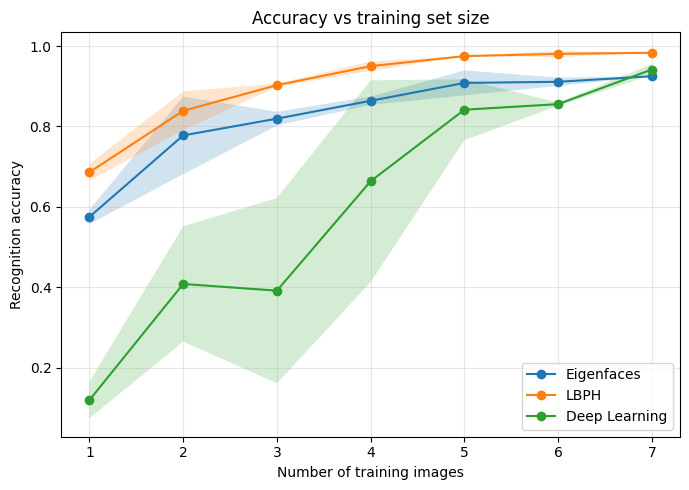

In [ ]:
data = load_orl("../data/ORL")
test_idx, pool_idx = make_fixed_test_indices(data, n_test=3, seed=0)
eigen_faces = Eigenfaces(K=10)
lbph = LBPH()

models = {
    "Eigenfaces": lambda: Eigenfaces(K=10),
    "LBPH": lambda: LBPH(),
    "Deep Learning": lambda: DeepLearningModel(),
}

train_sizes = [1, 2, 3, 4, 5, 6, 7]

results = evaluate_models_vs_train_size(
    models=models,
    train_sizes=train_sizes,
    data=data,
    test_idx=test_idx,
    pool_idx=pool_idx,
    n_exp=3,
    save_path="../logs/orl_learning_curves.json",
)

summary = summarize_results(results)
plot_learning_curves(summary)


=== Model: Eigenfaces ===
  train_size=2 (0/3 done)


  train_size=3 (0/3 done)


  train_size=4 (0/3 done)


  train_size=5 (0/3 done)


  train_size=6 (0/3 done)


  train_size=7 (0/3 done)


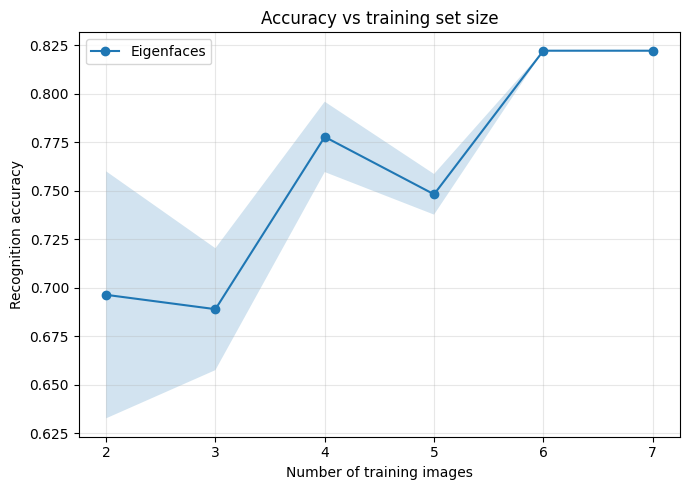

In [ ]:
from vic.dataloader import load_yale

data = load_yale("../data/Yale")
test_idx, pool_idx = make_fixed_test_indices(data, n_test=3, seed=0)
eigen_faces = Eigenfaces(K=10)
lbph = LBPH()

models = {
    "Eigenfaces": lambda: Eigenfaces(K=30),
    # "LBPH": lambda: LBPH(),
    # "Deep Learning": lambda: DeepLearningModel(),
}

train_sizes = [2, 3, 4, 5, 6, 7, 8]

results = evaluate_models_vs_train_size(
    models=models,
    train_sizes=train_sizes,
    data=data,
    test_idx=test_idx,
    pool_idx=pool_idx,
    n_exp=3,
    save_path="../logs/yale_learning_curves.json",
)

summary = summarize_results(results)
plot_learning_curves(summary)